# Comparing model input and output to observations - Vestland Climate Grid

**<span style="color:red">Attention!</span> This notebook requires a finished simulation of at least 10 years at one of the Vestland Climate Grid sites.**

This notebooks illustrates relating the CLM-FATES model output to available observational data from the Vestland Climate Grid. We use modelled and observed soil temperatures as an example. The workflow highlights common challenges for comparing ecological observations to LSM/DGVM data. General hurdles are...

- ...harmonizing the temporal and spatial scales (aggregated grid cell resolutions (km) vs. local observations (cm-m), decade to century scale simulations vs. few year observational studies, etc.)
- ...different jargon and scientific foci (e.g. variables of interest, species-level studies vs. PFT representation in models, etc.)
- ...data access, documentation, and formats

A main goal of the NorESM modelling platform is to improve the mutual understanding between ecological data collectors and the earth system modelling community. In addition to giving users easier access to running simulations, we want to showcase how common field observations relate to default model inputs and outputs. Simplified adjustments of the models to better represent small-scale conditions of field experiments may be a next crucial step to make LSMs and DGVMs a more attractive tool for data collectors.

The `Vestland Climate Grid` sites you can choose within the NorESM-LSP's GUI provide datasets for various 'classical' ecological experiments, for example, vegetation removal or artificial fertilization. This workflow example highly benefits from the fact that the VCG data follows the [FAIR principles](https://www.go-fair.org/fair-principles/) for data management and stewardship. We can directly access it from the open data management platform [OSF](https://osf.io/) and attain an easily reproducible analysis.

In this notebook, we will...
1. Load model output data
2. Plot the model observations alone
3. Download observational data from OSF
4. Plot the observational data
5. Plot modelled and observed data together

## Specify folders and load VCG data
start by loading necessary libraries:

In [3]:
import xarray as xr  # NetCDF data handling
import matplotlib.pyplot as plt  # Plotting
import time  # Keeping track of runtime
import json  # For reading data dictionaries stored in json format
import pandas as pd  # Tabular data analysis
import datetime as dt  # For workaround with long simulations (beyond year 2262)
from pathlib import Path  # For easy path handling

<span style="color:red">Attention!</span> **This workflow only works with existing model output for one of the following Vestland Climate Grid observation sites:**

In [4]:
with open(Path("../../config/sites.json"), 'r', encoding='utf-8') as lsp_sites_json:
    lsp_sites_dict = json.load(lsp_sites_json)
    
print(f"{'Site code':>9}{'Long name':>25}")
print('-'*34)
_ = [print(f"{cur_site['properties']['name']:>9}{cur_site['properties']['long_name']:>25}") for cur_site in lsp_sites_dict['features']
     if cur_site['properties']['group'] == "SeedClim"]

Site code                Long name
----------------------------------


KeyError: 'group'

Specify your model experiment caseID (full name of case folder) and site code:

In [5]:
# Add the full case name in quotation marks here! E.g.: "5994e825658b853b95d61feccffd18ad_bor1-1000y"
case_id = "bedb88a7930bbb185a52bf3e86d0a9fd_alp4-1000y-baseline"

# Enter the case ID (aka. short site code, see table above) in quotation marks here! E.g.: "BOR1".
# ATTENTION! This is case sensitive and important to find the right folder paths: use the correct capitalization of letters!
site_code = "ALP4"
# If you are unsure about the site code, you can try to uncomment the next two lines instead
#import glob
#site_code = Path(glob.glob(f"../../data/{case_id}/domain*.nc")[0]).name.split("_")[2]

# Path to the case's land archive output, i.e. the folder containing the `.nc` file(s) you want to analyse. 
# Only change this line if you renamed/moved the folder or moved files from the default location!
output_data_path = Path(f"../../cases/{case_id}/archive/lnd/")

### Enter the name(s) of the output file(s)
**<span style="color:red">Attention!</span> By default, the model produces many seperate output files (one per month). The following code assumes you have already concatenated them using the [combine_nc_files.ipynb](../../notebooks/combine_nc_files.ipynb) notebook.**

However, if you want to combine multiple files 'on the fly', you can uncomment the respective line in the next code cell and adapt it accordingly - note that this process can take some time!

In [6]:
# Enter the name of a single output file, for instance created with the 'combine_nc_files' notebook. For example:
file_path = f"{output_data_path}/bedb88a7930bbb185a52bf3e86d0a9fd_alp4-1000y-baseline.h0.1014-2014.nc"

# Optional: enter name to read in multiple output files
# The following line uses '*' wild card notation to combine all files from a given history tape on the fly
# file_path = f"{output_data_path}/hist/*h0*.nc"  # Example for reading in multiple files at once, i.e. all in the given folder for history tape zero

In [7]:
# Read data, normally no need to change
output_nc_data = xr.open_mfdataset(
    file_path,
    combine='by_coords',
    decode_times=True
)

---
## Modelled soil temperature
We will extract modelled soil temperature from the CLM-FATES simulation output and relate them to the counterpart measurements from the field. CLM-FATES mechanistically calculates soil temperature and heat transfer based on e.g. the atmospheric forcings, soil and land cover characteristics, and other modelled properties such as the snow cover or the radiative transer through the modelled vegetation. Note that due to the time mismatch between the available observational data and the climate forcing data we provide in the first NorESM-LSP release ([GSWP3](https://www.isimip.org/gettingstarted/details/4/)), we will not be able to compare the exact same points in time - but it does give us an idea if the model somewhat realistically represents the observed patterns.

By setting the `use_bedrock` flag to `True` when setting up a simulation, we tell parts of the model to use a site-specific soil depth rather than the full default ground column (visualised in a plot below). Overwriting the soil depth in this way is the NorESM-LSP default, but uses coarse depth-to-bedrock estimates from a global interpolated dataset that may not be very realistic for the VCG sites. This is an example for how we could use _in situ_ observational data to constrain the model **inputs**: we could also provide soil depth measurements from the site to directly manipulate the input surface data NetCDF file, rather than using values from a dataset.

The next code cells specify the variable name to look at, converts it from Kelvin to Cescius, and plots the depth levels in the soil column:

In [8]:
# Soil temperature history variable in CLM
var_name = "TSOI"

In [9]:
# Retrieve soil temperature from model output, convert to deg. C
model_soil_temp = output_nc_data[var_name] - 273.15
model_soil_temp.attrs["long_name"] = "Soil temperature per ground level"
model_soil_temp.attrs["units"] = "deg.C"
model_soil_temp

<xarray.DataArray 'TSOI' (time: 12000, levgrnd: 25, lndgrid: 1)>
dask.array<sub, shape=(12000, 25, 1), dtype=float32, chunksize=(12000, 25, 1), chunktype=numpy.ndarray>
Coordinates:
  * levgrnd  (levgrnd) float32 0.01 0.04 0.09 0.16 ... 13.33 19.48 28.87 42.0
  * time     (time) object 1014-02-01 00:00:00 ... 2014-01-01 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    long_name:  Soil temperature per ground level
    units:      deg.C

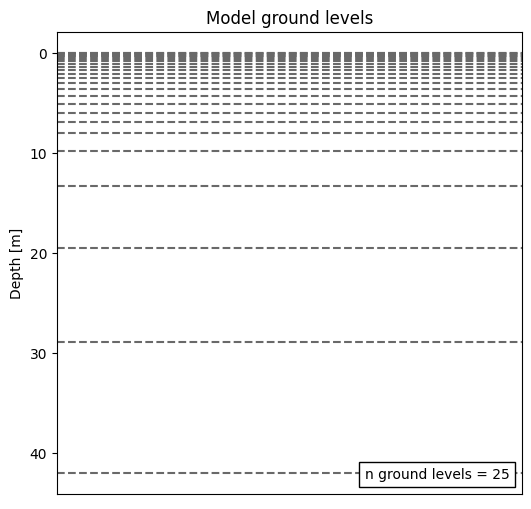

In [10]:
# Investigate the vertical resolution of the included ground levels. See:
# https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Ecosystem/CLM50_Tech_Note_Ecosystem.html#id17
from matplotlib.offsetbox import AnchoredText

fig, ax = plt.subplots(figsize=(6, 6))

for ground_level in model_soil_temp.levgrnd.values:
    
    ax.axhline(ground_level,
               color="#696969",
               linestyle="dashed",
              )
# Plot layout
ax.set_title("Model ground levels")
ax.set_ylabel("Depth [m]")
ax.get_xaxis().set_visible(False)
ax.invert_yaxis()

# Add text box to show number of ground levels
anchored_text = AnchoredText(f"n ground levels = {len(model_soil_temp.levgrnd.values)}", loc=4)
ax.add_artist(anchored_text)

Plot the modelled ground temperatures for the top 15 meters for the last 10 years of the simulation. Change `n_last_years` if the simulation was shorter than 10 years.

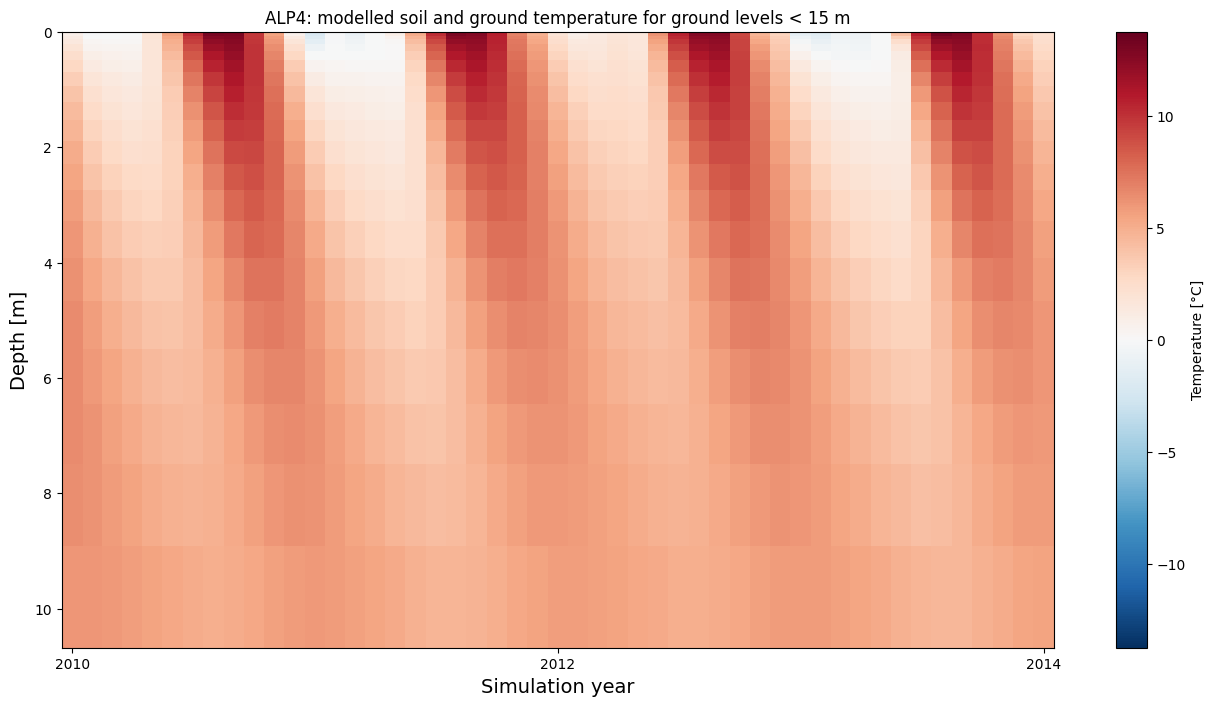

In [12]:
n_last_years = 5
max_depth = 15  # in meters
idx_soil_layers_15m = (model_soil_temp.levgrnd < max_depth).values.sum() - 1

fig, ax = plt.subplots(figsize=(16, 8))

color_bar_plot = model_soil_temp.isel(
    levgrnd=slice(0, idx_soil_layers_15m)
).where(
    model_soil_temp['time.year'] > (max(model_soil_temp['time.year']) - n_last_years), drop=True
).T.plot(ax=ax,
         cbar_kwargs={
             'label': "Temperature [°C]"
             }
        )

# Make plot more intuitive by setting depth=0 to the top
ax.invert_yaxis()

# Title and labels
ax.set_title(f"{site_code}: modelled soil and ground temperature for ground levels < 15 m")
ax.set_ylabel("Depth [m]", fontsize=14)
ax.set_xlabel("Simulation year", fontsize=14);

## Load observational data
Next, we will load the observational data. Refer to https://osf.io/4c5v2/ for the full documentation and additional information. We can directly download the data from OSF into a DataFrame using the Python code below.

**Citation**: Vandvik, V., Telford, R. J., Halbritter, A. H., Jaroszynska, F., Lynn, J. S., Geange, S. R., … Rüthers, J. (2022, April 5). FunCaB - The role of functional group interactions in mediating climate change impacts on the Carbon dynamics and biodiversity of alpine ecosystems. Retrieved from osf.io/4c5v2.

The next code cells will download the data, make some adjustments, and create monthly means that can be compared to the default monthly model output.

In [13]:
# Download data directly from OSF storage, make sure you are connected to the internet
vcg_soil_temp_obs_df = pd.read_csv("https://osf.io/7tgxb/download", low_memory=False)

In [14]:
# Print first rows
vcg_soil_temp_obs_df.head()

,year,date_time,siteID,blockID,plotID,iButtonID,treatment,soiltemperature,comments,turfID
0,2015,2015-07-12T17:58:01Z,Alrust,Alr3,Alr3GF,3BC3A141_2016,GF,15.475,NaN,NaN
1,2015,2015-07-12T20:22:01Z,Alrust,Alr3,Alr3GF,3BC3A141_2016,GF,14.911,NaN,NaN
2,2015,2015-07-12T22:46:01Z,Alrust,Alr3,Alr3GF,3BC3A141_2016,GF,14.347,NaN,NaN
3,2015,2015-07-13T01:10:01Z,Alrust,Alr3,Alr3GF,3BC3A141_2016,GF,13.846,NaN,NaN
4,2015,2015-07-13T03:34:01Z,Alrust,Alr3,Alr3GF,3BC3A141_2016,GF,13.532,NaN,NaN


In [15]:
# Read dictionary for mapping the name of the NorESM platform site codes to the corresponding name in the VCG dataset
with open(Path("./dicts/vestland_climate_grid.json"), 'r', encoding='utf-8') as vcg_site_json:
    vcg_site_dict = json.load(vcg_site_json).get("sites")

In [16]:
# Subset soil temperatures for utilized site
mysite_soil_temp_obs_df = vcg_soil_temp_obs_df[vcg_soil_temp_obs_df["siteID"] == vcg_site_dict[site_code]['osf_csv_name']]
mysite_soil_temp_obs_df.head()

,year,date_time,siteID,blockID,plotID,iButtonID,treatment,soiltemperature,comments,turfID
720079,2015,2015-09-15T01:36:01Z,Skjelingahaugen,Skj4,Skj4GB,3E32F741_2016,GB,8.110,NaN,NaN
720080,2015,2015-09-15T04:00:01Z,Skjelingahaugen,Skj4,Skj4GB,3E32F741_2016,GB,7.984,NaN,NaN
720081,2015,2015-09-15T06:24:01Z,Skjelingahaugen,Skj4,Skj4GB,3E32F741_2016,GB,7.796,NaN,NaN
720082,2015,2015-09-15T08:48:01Z,Skjelingahaugen,Skj4,Skj4GB,3E32F741_2016,GB,7.733,NaN,NaN
720083,2015,2015-09-15T11:12:01Z,Skjelingahaugen,Skj4,Skj4GB,3E32F741_2016,GB,7.796,NaN,NaN


In [17]:
# Print period for available measurements
print(f"From: {min(mysite_soil_temp_obs_df['date_time'])}")
print(f"To: {max(mysite_soil_temp_obs_df['date_time'])}")

From: 2015-09-15T00:00:01Z
To: 2016-07-02T23:58:01Z


Calculate and display monthly and yearly means:

In [18]:
# Next we calculate monthly means
monthly_mean_df = mysite_soil_temp_obs_df.groupby(
    pd.PeriodIndex(mysite_soil_temp_obs_df['date_time'], freq='M')
)['soiltemperature'].mean()

# Convert to DataFrame
monthly_mean_df = monthly_mean_df.to_frame()

In [19]:
monthly_mean_df

,soiltemperature
date_time,
2015-09,6.961438
2015-10,3.761712
2015-11,1.457354
2015-12,0.364459
2016-01,0.283917
2016-02,0.280174
2016-03,0.257236
2016-04,0.226174
2016-05,0.195519


In [20]:
# Calculate yearly mean (to enable yearly comparison to model output)
monthly_mean_df['date_dt'] = pd.to_datetime(monthly_mean_df.index.to_timestamp())
monthly_mean_df.groupby(monthly_mean_df.date_dt.dt.year)['soiltemperature'].transform('mean')
monthly_mean_df = monthly_mean_df.reset_index()
# Add integer month column for easier data handling later on
monthly_mean_df['month_int'] = [int(pd.to_datetime(x).strftime('%m')) for x in monthly_mean_df['date_dt'].values]
monthly_mean_df

,date_time,soiltemperature,date_dt,month_int
0,2015-09,6.961438,2015-09-01,9
1,2015-10,3.761712,2015-10-01,10
2,2015-11,1.457354,2015-11-01,11
3,2015-12,0.364459,2015-12-01,12
4,2016-01,0.283917,2016-01-01,1
5,2016-02,0.280174,2016-02-01,2
6,2016-03,0.257236,2016-03-01,3
7,2016-04,0.226174,2016-04-01,4
8,2016-05,0.195519,2016-05-01,5
9,2016-06,5.712489,2016-06-01,6


Then plot the observed data:

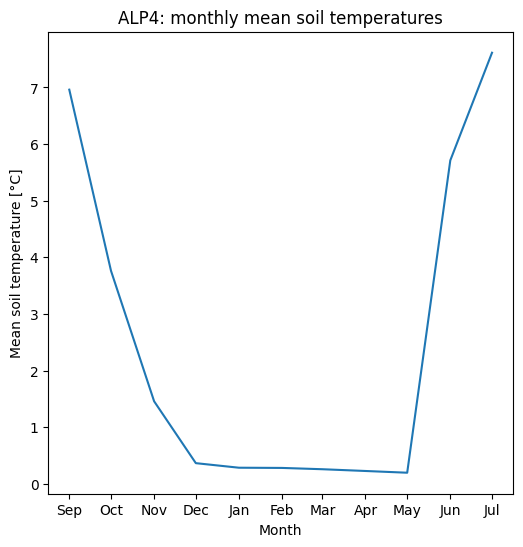

In [21]:
# Plot for quick visualization
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(monthly_mean_df['date_dt'],
        monthly_mean_df['soiltemperature']
       )
ax.set_title(f"{site_code}: monthly mean soil temperatures")
ax.set_xlabel("Month")
ax.set_ylabel("Mean soil temperature [°C]")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

## Modelled and observed in one plot
The observation plot above shows averages from multiple temperature loggers buried at approximately 5 cm depth. We thus calculate the arithmetic mean of the 2nd and 3rd CLM default ground layers (node depths: 4cm and 9cm, respectively) for comparison. We use the range of temperatures for the last 10 simulation years. For interpretation, keep in mind that this exercise makes most sense when the utilized model simulation has been properly spun up and the utilized climate forcings within and before that period are comparable to the measurements' observation dates. In addition, comparing the broader scale default CLM-FATES output to the small-scale observations can result in comparing the soil temperatures of modelled areas with e.g. tree cover to tree-free patches of grass, which are the study focus of the VCG data.

In [22]:
# Extract top soil layers (around 10cm), subset last n simulation years defined above, calculate monthly averages (from default 3h model timesteps)
top_2_layer_10y_soil_temp = model_soil_temp.isel(
    levgrnd=slice(1, 3)
).where(
    model_soil_temp['time.year'] > (max(model_soil_temp['time.year']) - n_last_years), drop=True
).mean(
    dim="levgrnd"
).resample(time='1M').mean()

In [23]:
# Determine maximum and minimum temperatures over given period
monthly_modelled_max_soil_temp_df = \
top_2_layer_10y_soil_temp.groupby("time.month").max().to_dataframe().reset_index(level=['month', 'lndgrid'])

monthly_modelled_min_soil_temp_df = \
top_2_layer_10y_soil_temp.groupby("time.month").min().to_dataframe().reset_index(level=['month', 'lndgrid'])

In [24]:
# Map modelled monthly values to observed monthly values
monthly_mean_df['model_max_of_mean_monthly_soil_temp'] = None
monthly_mean_df['model_min_of_mean_monthly_soil_temp'] = None

for cur_month in monthly_mean_df['month_int']:
    
    # Max temperatures
    monthly_mean_df.loc[(monthly_mean_df['month_int'] == cur_month),
                        'model_max_of_mean_monthly_soil_temp'] = \
    monthly_modelled_max_soil_temp_df.loc[(monthly_modelled_max_soil_temp_df['month'] == cur_month), 'TSOI'].values
    
    # Min temperatures
    monthly_mean_df.loc[(monthly_mean_df['month_int'] == cur_month),
                        'model_min_of_mean_monthly_soil_temp'] = \
    monthly_modelled_min_soil_temp_df.loc[(monthly_modelled_min_soil_temp_df['month'] == cur_month), 'TSOI'].values

# Convert datatype from object to float (prevents bug in plotting)
monthly_mean_df['model_max_of_mean_monthly_soil_temp'] = monthly_mean_df['model_max_of_mean_monthly_soil_temp'].astype(float)
monthly_mean_df['model_min_of_mean_monthly_soil_temp'] = monthly_mean_df['model_min_of_mean_monthly_soil_temp'].astype(float)
monthly_mean_df

,date_time,soiltemperature,date_dt,month_int,model_max_of_mean_monthly_soil_temp,model_min_of_mean_monthly_soil_temp
0,2015-09,6.961438,2015-09-01,9,12.843994,12.541138
1,2015-10,3.761712,2015-10-01,10,10.679749,9.125031
2,2015-11,1.457354,2015-11-01,11,6.923309,4.834198
3,2015-12,0.364459,2015-12-01,12,5.010254,0.963470
4,2016-01,0.283917,2016-01-01,1,2.227844,-1.950317
5,2016-02,0.280174,2016-02-01,2,0.965698,-1.467026
6,2016-03,0.257236,2016-03-01,3,1.240921,-0.796539
7,2016-04,0.226174,2016-04-01,4,1.732468,-0.694183
8,2016-05,0.195519,2016-05-01,5,1.848602,-0.033142
9,2016-06,5.712489,2016-06-01,6,6.038376,3.797516


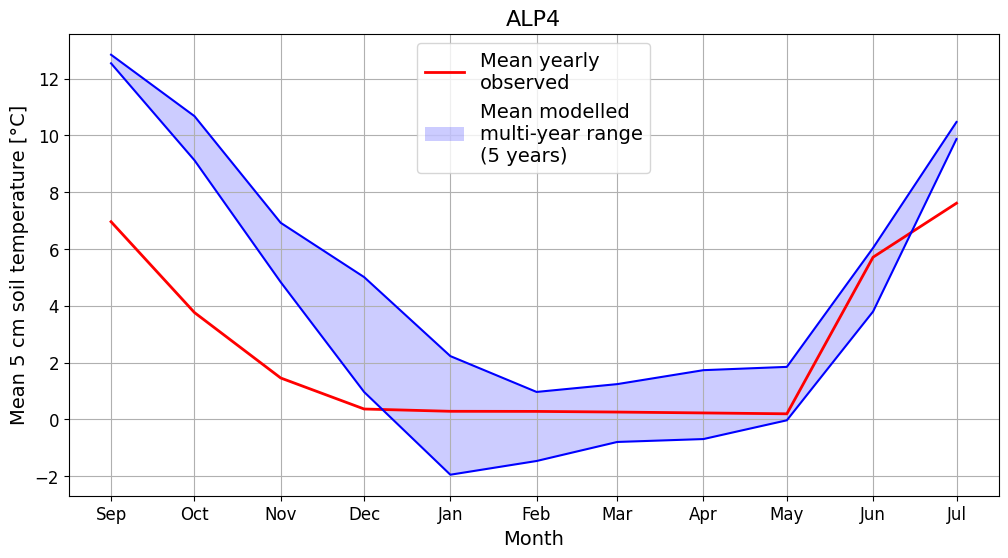

In [25]:
# Create plot
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(monthly_mean_df['date_dt'],
        monthly_mean_df['soiltemperature'],
        color="red",
        linewidth=2,
        label="Mean yearly\nobserved"
       )

ax.plot(monthly_mean_df['date_dt'],
        monthly_mean_df['model_max_of_mean_monthly_soil_temp'],
        color="blue"
       )
ax.plot(monthly_mean_df['date_dt'],
        monthly_mean_df['model_min_of_mean_monthly_soil_temp'],
        color="blue"
       )


ax.fill_between(monthly_mean_df['date_dt'], 
                monthly_mean_df['model_min_of_mean_monthly_soil_temp'],
                monthly_mean_df['model_max_of_mean_monthly_soil_temp'],
                alpha=0.2,
                facecolor="blue",
                label=f"Mean modelled\nmulti-year range\n({n_last_years} years)"
               )

# Plot layout
ax.set_title(f"{site_code}", fontsize=16)
ax.set_ylabel("Mean 5 cm soil temperature [°C]", fontsize=14)
ax.set_xlabel("Month", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.legend(fontsize=14)
ax.grid()